In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_low_rank_matrix, make_blobs
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Setup a test problem 

In [2]:
def make_kernel_matrix(npts, kernel, std = 0.2):
    """ Construct K = k(x_i,x_j) where x_i are well-separated clusters"""
    
    X, _  = make_blobs(n_samples = npts, centers = 2,
                           random_state=0, cluster_std=std, shuffle = False)
    

    from sklearn.neighbors import DistanceMetric
    dist = DistanceMetric.get_metric('euclidean')
    R = dist.pairwise(X)

    #Construct kernel matrices
    K = kernel(R)[:npts/2,npts/2:]    
    
    return K, X


Text(0.5,1,'Interacting points')

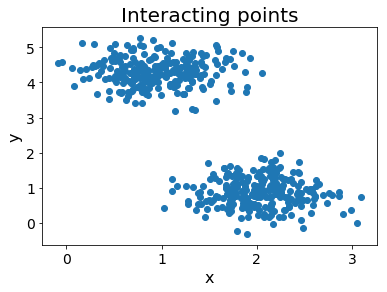

In [3]:
#Create the kernel and the kernel matrix
kernel = lambda x: np.exp(-x/0.2)
A, pts = make_kernel_matrix(512, kernel, std = 0.4)

# Plot the two sets of blobs
plt.figure()
plt.scatter(pts[:,0],pts[:, 1])
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.title('Interacting points', fontsize = 20)

### Plot the singular values of this matrix. 

Text(0.5,1,'Singular Values of Interaction matrix')

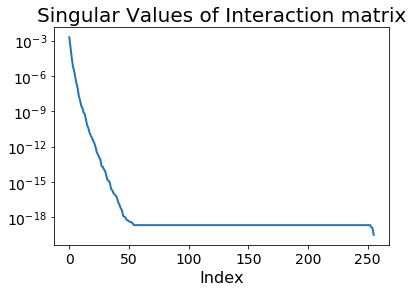

In [4]:
u,s,vh = np.linalg.svd(A)

plt.figure()
plt.semilogy(s, linewidth = 2.0)
plt.xlabel('Index', fontsize = 16)
plt.title('Singular Values of Interaction matrix', fontsize = 20)

## 1. Implement basic randomized SVD method

In [5]:
def randsvd(A, k, p = 20):
    m,n = A.shape
    # Draw random matrix
    Omega = np.random.randn(n, k+p)
    
    #1. Randomized range finder
    Y = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    
    #2. Compute truncated SVD
    B = np.dot(q.T,A)
    u,s,vh = np.linalg.svd(B, full_matrices = False)
    u = np.dot(q,u[:,:k])
    
    return u,s[:k],vh[:k,:]

### How accurate is the low-rank approximation?

In [6]:
#Compute Frobenius norm of A
Anrm = np.sqrt(np.sum(s**2.))

klst = range(5,100,5)
n = len(klst)

#Error in the 2 and Frobenius norm
err_svd = np.zeros((n,2), dtype = 'd')
err_rsvd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    ur,sr,vrh = randsvd(A, k, p = 10)
    Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
    
    #2-norm
    err_svd[i,0]  = s[k]/s[0]
    err_rsvd[i,0] = np.linalg.norm(A-Ah,2)/s[0] 
    
    #Frobenius norm
    err_svd[i,1]  = np.sqrt(np.sum(s[k:]**2.))/Anrm
    err_rsvd[i,1] = np.linalg.norm(A-Ah,'fro')/Anrm
    

Text(0.5,1,'Frobenius-norm ')

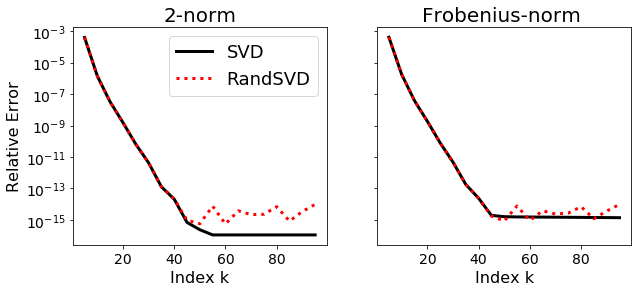

In [7]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(klst,err_svd[:,0],  'k-', klst,err_rsvd[:,0], 'r:', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend({'SVD','RandSVD'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(klst,err_svd[:,1],  'k-', klst,err_rsvd[:,1], 'r:', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

### How accurate are the singular values?

Text(0.5,1,'Singular Values')

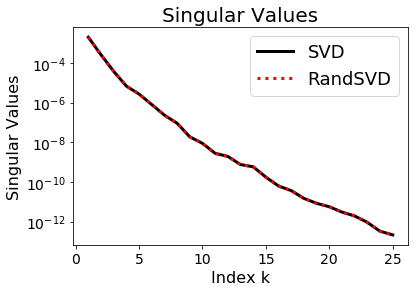

In [8]:
k = 25 #Target rank
_, sh, _ = randsvd(A, k, p = 5)
plt.figure()
plt.semilogy(np.arange(k)+1,s[:k],  'k-',np.arange(k)+1, sh, 'r:', linewidth = 3.0)
plt.xlabel('Index k', fontsize = 16)
plt.ylabel('Singular Values', fontsize = 16)
plt.legend({'SVD','RandSVD'}, fontsize = 18)
plt.title('Singular Values', fontsize = 20)

### How is the accuracy affected by decay of the singular values?

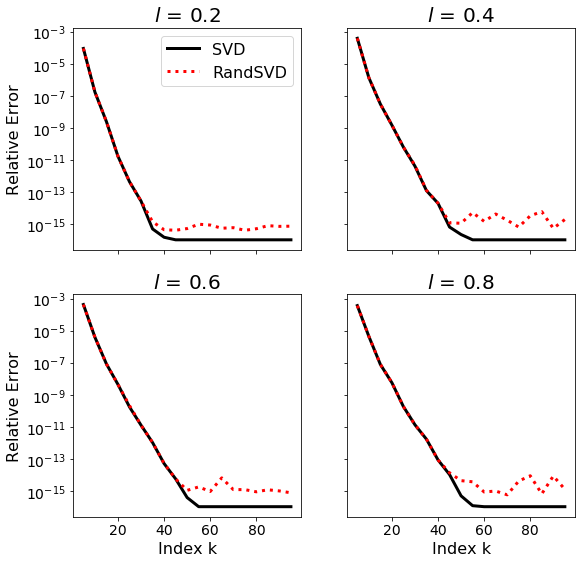

In [9]:
llst = [0.2,0.4,0.6,0.8] #Correlation length affects the decay of singular values

klst = range(5,100,5)
n = len(klst)

f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize=(9,9))
for l,ax,j in zip(llst,axarray.flatten(),range(4)):
    
    kernel = lambda x: np.exp(-(x/(0.5*l)))
    A, pts = make_kernel_matrix(512, kernel, std = 0.4)
    
    u,s,vh = np.linalg.svd(A)
    
    err_svd = np.zeros((n,), dtype = 'd')
    err_rsvd = np.zeros((n,), dtype = 'd')
    for i,k in enumerate(klst):
        ur,sr,vrh = randsvd(A, k, p = 5)
        Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
    
        #2-norm
        err_svd[i]  = s[k]/s[0]
        err_rsvd[i] = np.linalg.norm(A-Ah,2)/s[0] 
        
        
    ax.semilogy(klst,err_svd,  'k-', klst,err_rsvd, 'r:', linewidth = 3.0)
    if j > 1:  ax.set_xlabel('Index k', fontsize = 16)
    if j%2 == 0:  ax.set_ylabel('Relative Error', fontsize = 16)
    if j == 0:  ax.legend({'SVD','RandSVD'}, fontsize = 16, loc = 'upper right')
    ax.set_title('$l$ = ' + str(l), fontsize = 20)


### Effect of oversampling parameter p on the accuracy

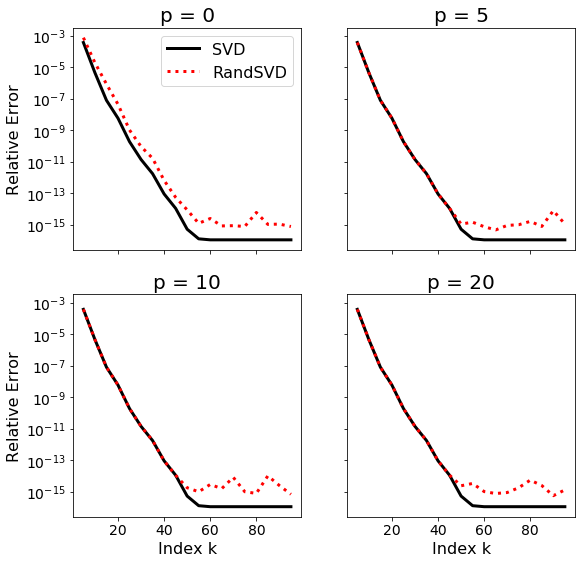

In [10]:
plst = [0,5,10,20]

f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize=(9,9))
for p,ax,j in zip(plst,axarray.flatten(),range(4)):
    err_svd = np.zeros((n,), dtype = 'd')
    err_rsvd = np.zeros((n,), dtype = 'd')
    for k,i in zip(klst,range(n)):
        ur,sr,vrh = randsvd(A, k, p = p)
        Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
    
        #2-norm
        err_svd[i]  = s[k]/s[0]
        err_rsvd[i] = np.linalg.norm(A-Ah,2)/s[0] 
        
        
    ax.semilogy(klst,err_svd,  'k-', klst,err_rsvd, 'r:', linewidth = 3.0)
    if j > 1:  ax.set_xlabel('Index k', fontsize = 16)
    if j%2 == 0:  ax.set_ylabel('Relative Error', fontsize = 16)
    if j == 0:  ax.legend({'SVD','RandSVD'}, fontsize = 16, loc = 'upper right')
    ax.set_title('p = ' + str(p), fontsize = 20)

### Effect of randomization - takes a while to run

Text(0.5,1,'Singular Values')

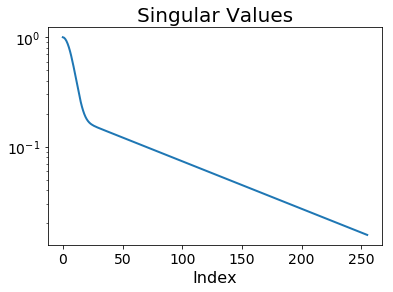

In [11]:
nsamples = 500
klst = [20,50,75,100]

from sklearn.datasets import make_low_rank_matrix
A = make_low_rank_matrix(256,256, 10, tail_strength=0.2)
u,s,vh = np.linalg.svd(A, full_matrices = False)


plt.figure()
plt.semilogy(s, linewidth = 2.0)
plt.xlabel('Index', fontsize = 16)
plt.title('Singular Values', fontsize = 20)



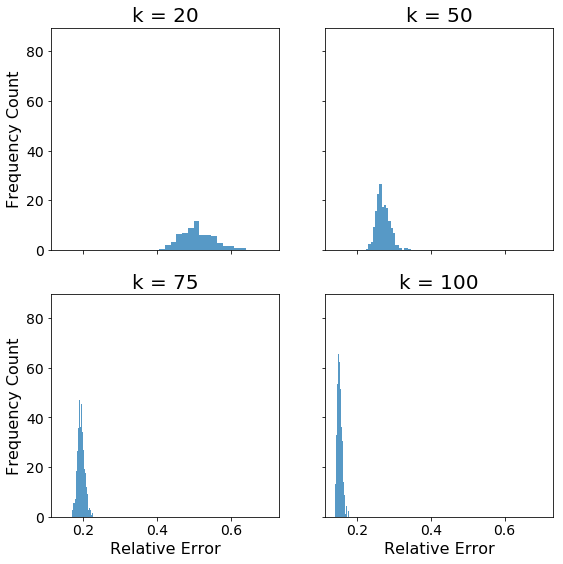

In [12]:
f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize=(9,9))
for k, ax, j in zip(klst,axarray.flatten(),range(4)):
    err_rsvd = np.zeros((nsamples,), dtype = 'd')
    
    for i in range(nsamples):
        ur,sr,vrh = randsvd(A, k, p = 5)
        Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
        err_rsvd[i] = np.linalg.norm(A-Ah,2)/s[0] 
        
    
    n, bins, patches = ax.hist(err_rsvd, 20, alpha=0.75, density = True)
    if j > 1:  ax.set_xlabel('Relative Error', fontsize = 16)
    if j%2 == 0:  ax.set_ylabel('Frequency Count', fontsize = 16)
    ax.set_title('k = ' + str(k), fontsize = 20)

## 2. A large-scale example

Target names ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
Size of images  (1348, 62, 47)
Shape of data (1348, 2914)


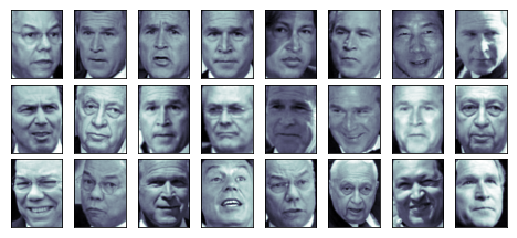

In [13]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print "Target names", faces.target_names
print "Size of images ", faces.images.shape
print "Shape of data", faces.data.shape


fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i,:].reshape(62, 47), cmap='bone')

### Compare the computational cost of different methods

In [14]:
k = 150 # target rank
p = 20  # oversampling

#Compute using randomized method
print "Timing using randomized method"
%timeit u,s,vh = randsvd(faces.data,k,p)
u,s,vh = randsvd(faces.data,k,p)

#Compute the full SVD
print "Timing using full SVD"
%timeit u,sf,vh = np.linalg.svd(faces.data, full_matrices = False)
u,sf,vh = np.linalg.svd(faces.data, full_matrices = False)

Timing using randomized method
10 loops, best of 3: 145 ms per loop
Timing using full SVD
1 loop, best of 3: 1.58 s per loop


### Compare singular values

Text(0.5,1,'Comparing accuracy')

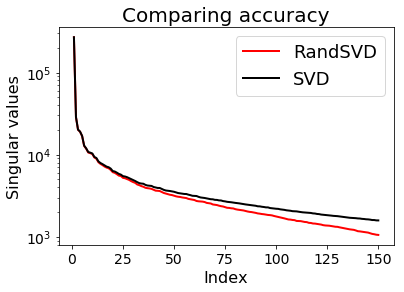

In [15]:
plt.figure()

plt.semilogy(range(1,151), s, 'r-', range(1,151),  sf[:150], 'k-', linewidth = 2.0 )
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Singular values', fontsize = 16)
plt.legend(('RandSVD','SVD'), fontsize = 18)
plt.title('Comparing accuracy', fontsize = 20)

### Plot eigenfaces

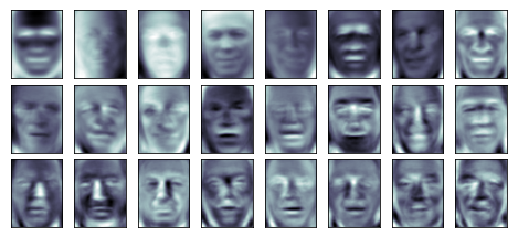

In [16]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(vh[i,:].reshape(62, 47), cmap='bone')